In [27]:
model = "PRIMNET"
dataset = "FINGER"
path = f"{model}/{dataset}"

from path_handler import get_BASERDIR
import os
BASEDIR, RUNMODE = get_BASERDIR(".")

if BASEDIR.absolute().name == "control":
    os.chdir("..")
os.getcwd()

Running on Jupyter...


'/home/taerim/sOftrobot/PRIMNET-V2/code'

In [28]:
# %%
from pathlib import Path
import sys

try: 
    get_ipython().__class__.__name__
    BASEDIR = Path().absolute()
except: BASEDIR = Path(__file__).parent

sys.path.append(str(BASEDIR))
import torch
from torch import nn
import argparse

import numpy as np
from utils import dataloader
from utils.initalize import INITALZE_EVEN_JOINTS
from utils.update import  update_primnet, update_fc_primnet, update_pcc_primnet


import os
import random
from pathlib import Path
import wandb
import time
import json

from utils.tools import set_seed, set_wandb, print_log_dict, prefix_dict, average_dict
from utils.path_handler import JUPYTER, RUN, DEBUG, get_BASERDIR
from utils.args import read_ARGS
from utils.logger import CSVLogger,ask_and_make_folder
from utils.tools import cast_numpy

from configs.template import PRIMNET_ARGS_TEMPLATE, FC_PRIMNET_ARGS_TEMPLATE, PCC_PRIMNET_ARGS_TEMPLATE
from model.PRIMNET import PRIMNET
from model.FC_PRIMNET import FC_PRIMNET
from typing import Union

from utils.dataloader import get_dataset, Sampler

In [29]:
BASEDIR, RUNMODE = get_BASERDIR(os.getcwd())
args = read_ARGS((BASEDIR/'results'/path/"args.py").absolute())
args

Running on Jupyter...


ARGS(MODEL='PRIMNET', EVEN_JOINTS=True, WANDB=True, pname='PRIMNET_v2.2', runname='FINGER', DATASET='FINGER', TPOSE=((0, 0, 0.12),), LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, EVEN_JOINT=True, p_offset_std=0.1, rpy_offset_std=0.01, axis_std=0.1, OUTPUT_NORMALIZE=False, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, w_vec=0.1, epochs=2000, focus_ratio=0.2, data_ratio=1.0, n_workers=2, batch_size=64, joint_seqs=('T', 'R', 'R', 'R', 'R', 'T', 'P'), marker_num=1, motor_dim=2)

In [30]:
if args.MODEL == 'PRIMNET':
    model = PRIMNET(args=args).to(args.device)
elif args.MODEL == 'FC_PRIMNET':
    model = FC_PRIMNET(args=args).to(args.device)

model.load_state_dict(torch.load(BASEDIR/'results'/path/"weights/epoch_1000.pth"))

<All keys matched successfully>

In [31]:
def forward_motor(model:PRIMNET, motor_control):     
    motor_control = model.normalize(motor_control)
    
    # Forward
    act_embeds = model.ACT_EMBED.layers(motor_control)
    q_values = model.FK_LAYER.forward_q(act_embeds)
    joint_se3 = model.FK_LAYER.forward_kinematics(q_values)
    
    return model.t2p(joint_se3, OUTPUT_NORMALIZE=False)



## Forward Kinematics

In [32]:
train_dataset,val_dataset,test_dataset,ext_dataset  = get_dataset(f"../dataset/{dataset}.json", args.data_ratio)

In [33]:
model.motor_mean, model.motor_std, model.position_mean, model.position_std

(tensor([-5.2485, 43.6342]),
 tensor([586.5966, 605.7722]),
 tensor([[0.],
         [0.],
         [0.]]),
 tensor([[1.],
         [1.],
         [1.]]))

In [34]:
# from matplotlib import pyplot as plt
# from matplotlib import patches

# def get_cmap(n, name='hsv'):
#     '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.'''
#     return plt.cm.get_cmap(name, n)



# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# length = 3
# start_point = random.randint(0, 1000)
# cmap = get_cmap(len(train_dataset.position[start_point:start_point+length]))

# for i, (pos,actuation) in enumerate(
#     zip(train_dataset.position[start_point:start_point+length],
#         train_dataset.motor_control[start_point:start_point+length])):
    
    
#     pos_ = pos[0,:,0]
#     ax.scatter(pos_[0], pos_[1], pos_[2], c=cmap(i))
    
#     actuation = actuation/10_000
#     ax.scatter(actuation[0], actuation[1], 0, c=cmap(i))
    
#     ax.set_xlabel('X Label')
#     ax.set_ylabel('Y Label')
#     ax.set_zlabel('Z Label')

# plt.show()
    

In [35]:
np.arange(0.01, 0.05, 0.02)

array([0.01, 0.03])

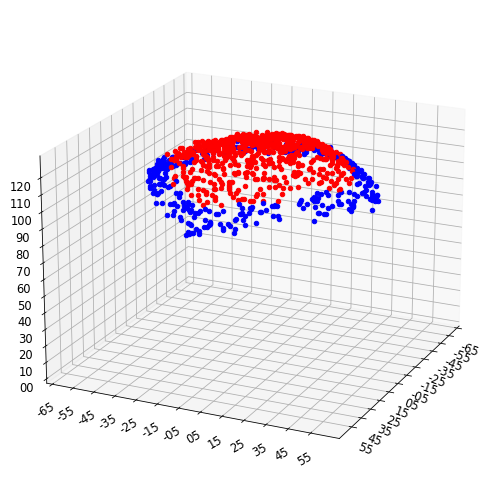

In [36]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')

for pos in train_dataset.position:
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0]*1000, pos_[1]*1000, pos_[2]*1000, c='r')
    

for pos in ext_dataset.position:
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0]*1000, pos_[1]*1000, pos_[2]*1000, c='b')

xlim = np.array([-65,65])
ylim = np.array([-65,65])
zlim = np.array([-0,130])

ax.set_xticks(np.arange(xlim[0],xlim[1],10), fontsize=12)
ax.set_yticks(np.arange(ylim[0],ylim[1],10), fontsize=12)
ax.set_zticks(np.arange(zlim[0],zlim[1],10), fontsize=12)

ax.set_xticklabels(np.arange(xlim[0],xlim[1],10), fontsize=11.5, rotation=-20)
ax.set_yticklabels(np.arange(ylim[0],ylim[1],10), fontsize=11.5, rotation=30)
ax.set_zticklabels(np.arange(zlim[0],zlim[1],10), fontsize=11.5)


from matplotlib.ticker import FormatStrFormatter

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2d'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2d'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2d'))

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)

# for actuation in train_dataset.motor_control:
#     actuation = actuation/10_000
#     ax.scatter(actuation[0], actuation[1], 0, c='k')

ax.view_init(elev=20, azim=25)
plt.show()

In [37]:
m = torch.mean(train_dataset.position,dim=0)
torch.min(train_dataset.position,dim=0)[0]-m, torch.max(train_dataset.position,dim=0)[0]-m

(tensor([[[-0.0461],
          [-0.0471],
          [-0.0133]]]),
 tensor([[[0.0449],
          [0.0413],
          [0.0087]]]))

In [38]:
torch.max(train_dataset.motor_control)

tensor(1433.0317)

In [39]:
rest_pos = model(torch.zeros(1,2).to(torch.float))[0,-1].detach().numpy()

In [40]:
idx = 4

train_dataset.motor_control[idx], train_dataset.position[idx]

(tensor([-604.5219,  754.0942]),
 tensor([[[-0.0292],
          [-0.0141],
          [ 0.1159]]]))

tensor([[341.9873,  30.7242]])
tensor([-0.0003,  0.0099,  0.1244])


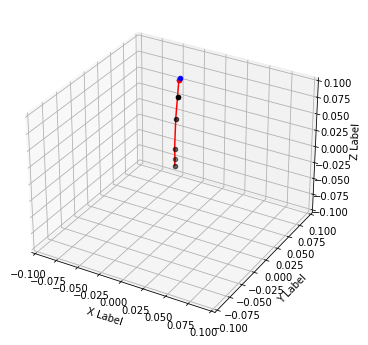

tensor([[-734.9996,  328.2905]])
tensor([-0.0177, -0.0222,  0.1178])


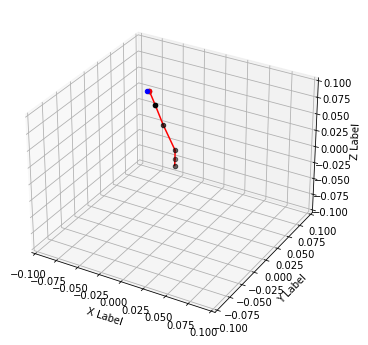

tensor([[-652.3622,  -43.2989]])
tensor([-0.0045, -0.0258,  0.1204])


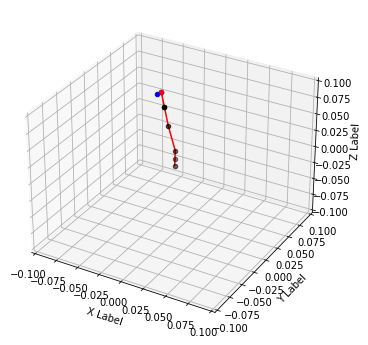

tensor([[-1378.7019,  -247.9432]])
tensor([-0.0044, -0.0433,  0.1067])


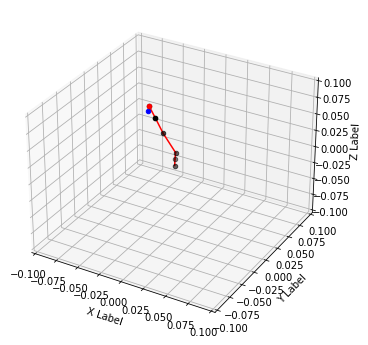

tensor([[-521.4277, -560.4946]])
tensor([ 0.0114, -0.0182,  0.1178])


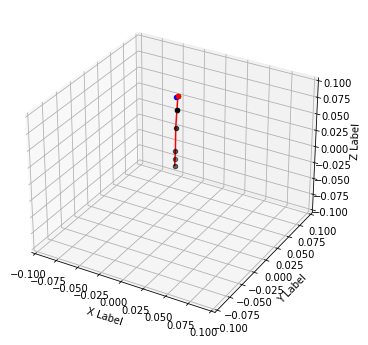

tensor([[-391.9182, -988.1289]])
tensor([ 0.0267, -0.0133,  0.1122])


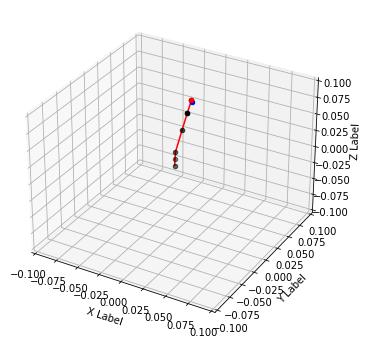

tensor([[-479.3078,  -54.9767]])
tensor([-0.0022, -0.0223,  0.1224])


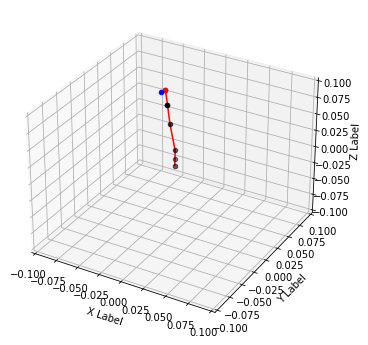

tensor([[ 94.5056, -36.5202]])
tensor([0.0036, 0.0026, 0.1258])


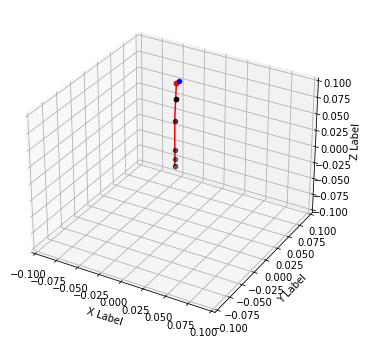

tensor([[ 44.1533, 129.2360]])
tensor([-0.0016,  0.0060,  0.1256])


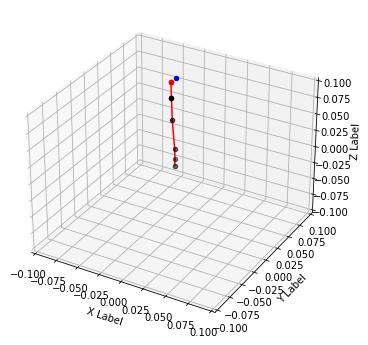

tensor([[-128.5803, -503.0440]])
tensor([ 0.0163, -0.0039,  0.1211])


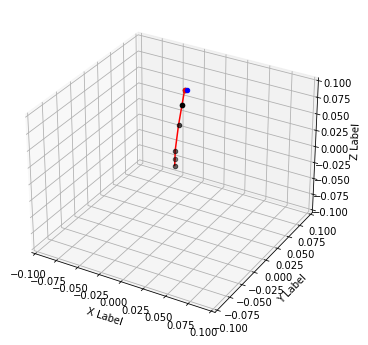

In [41]:
from matplotlib import pyplot as plt


for idx in range(10,20):

    motor_control = train_dataset.motor_control[idx][None,:]
    print(motor_control)
    target_position = train_dataset.position[idx].flatten()
    print(target_position)

    ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()
    # ps[-1,:], target_position

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')

    ps = np.vstack([np.array([0,0,0]), ps])

    i = 0
    for p in ps:
        i = i +1
        ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1 + 0.2)
    
    ax.scatter(p[0], p[1],p[2], color = 'r', alpha = 1)

    for p_fr, p_to in zip(ps[:-1], ps[1:]):
        ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

    ax.scatter(target_position[0], target_position[1], target_position[2], color='b')

    ax.set_xlim(-0.10, 0.10)
    ax.set_ylim(-0.10, 0.10)
    ax.set_zlim(-0.10, 0.10)
    
    # name x,y,z label to ax
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    
    # ax.view_init(elev=90, azim=0)

    plt.show()




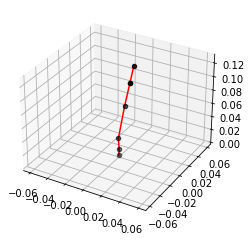

array([0.00083735, 0.02769461, 0.11686115], dtype=float32)

In [42]:
motor_control = torch.FloatTensor([1000,0]).unsqueeze(0)
ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# ax.scatter(0,0,0,color='k')

i = 0
for p in ps:
    i = i +1
    ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.05+0.5)

for p_fr, p_to in zip(ps[:-1], ps[1:]):
    ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

ax.set_xlim(-0.065, 0.065)
ax.set_ylim(-0.065, 0.065)
ax.set_zlim(-0, 0.13)
plt.show()

# print(ps[-1,:,0])
ps[-1]

In [43]:
n_resolution = 50

<Figure size 432x288 with 0 Axes>

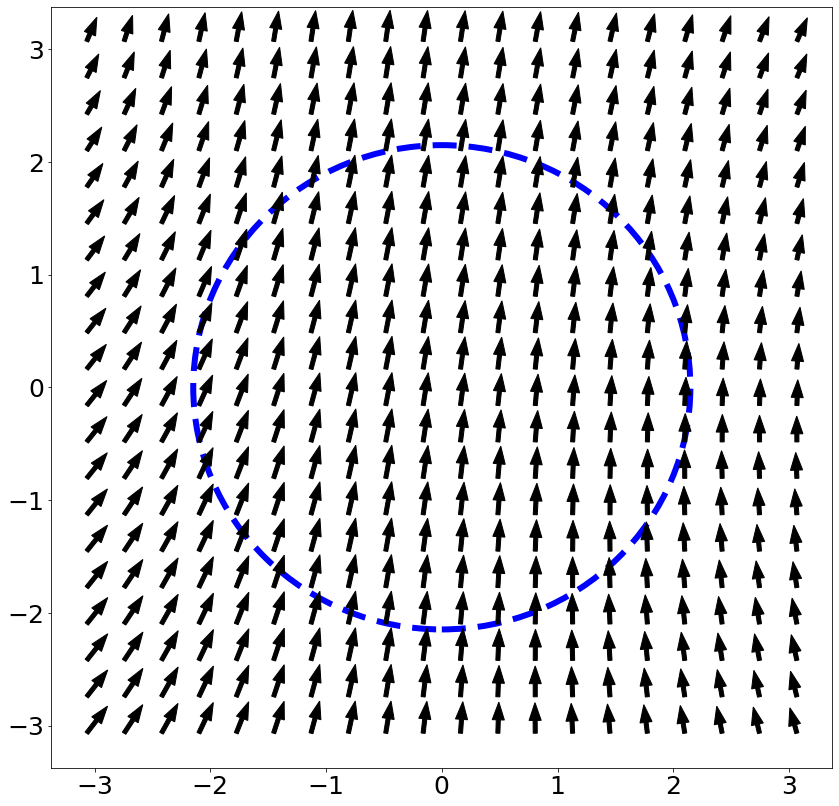

<Figure size 432x288 with 0 Axes>

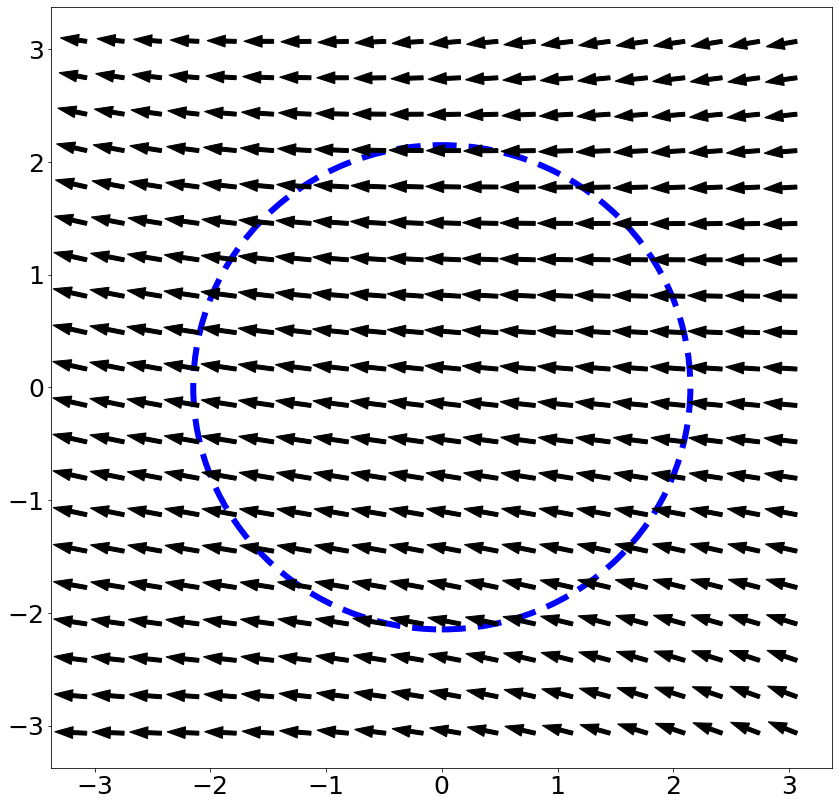

In [44]:
from jacobian import jacobian
from functools import partial

def forward_soro(soro,actuation):
    ps = soro(actuation)
    pos_EE = ps[:,-1,0:2,0]

    return pos_EE

# plot jacobian field
scale = 7
PI = np.pi
actuation_scale = 1/4096 * 2*PI 
r = 1400* actuation_scale

x = torch.linspace(-2000, 2000, 20)
y = torch.linspace(-2000, 2000, 20)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

fig = plt.figure()
fig, ax = plt.subplots(figsize=(14,14))

# plot range of training data 
circle=plt.Circle((0,0),r, linewidth=6, edgecolor='b', facecolor='none', linestyle=(1,(4,2)), label="Training Data Range")
ax.add_patch(circle)
plt.arrow(x,y, 0,0, color='k', alpha=1, width=0, label='Gradient Field')

# Actuation 1
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act1 = jac[0,:,0,0] * scale / actuation_scale
    
    # plot field
    ax.arrow(x* actuation_scale, y* actuation_scale, jac_act1[0], jac_act1[1], color='k', alpha=1, width=0.035)
    
plt.xlim(-2200* actuation_scale, 2200* actuation_scale)
plt.ylim(-2200* actuation_scale, 2200* actuation_scale)
# ax.legend(fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()    

fig = plt.figure()
fig, ax = plt.subplots(figsize=(14,14))

# plot range of training data 
circle=plt.Circle((0,0),r, linewidth=6, edgecolor='b', facecolor='none', linestyle=(1,(4,2)), label="Training Data Range")
ax.add_patch(circle)
plt.arrow(x,y, 0,0, color='k', alpha=1, width=0, label='Gradient Field')

# Actuation 2
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act2 = jac[0,:,0,1] * scale / actuation_scale

    # plot field
    plt.arrow(x* actuation_scale, y* actuation_scale, jac_act2[0], jac_act2[1], color='k', alpha=1, width=0.035)
    
    
plt.xlim(-2200* actuation_scale, 2200* actuation_scale)
plt.ylim(-2200* actuation_scale, 2200* actuation_scale)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# ax.legend(fontsize=20)
plt.show()


<Figure size 432x288 with 0 Axes>

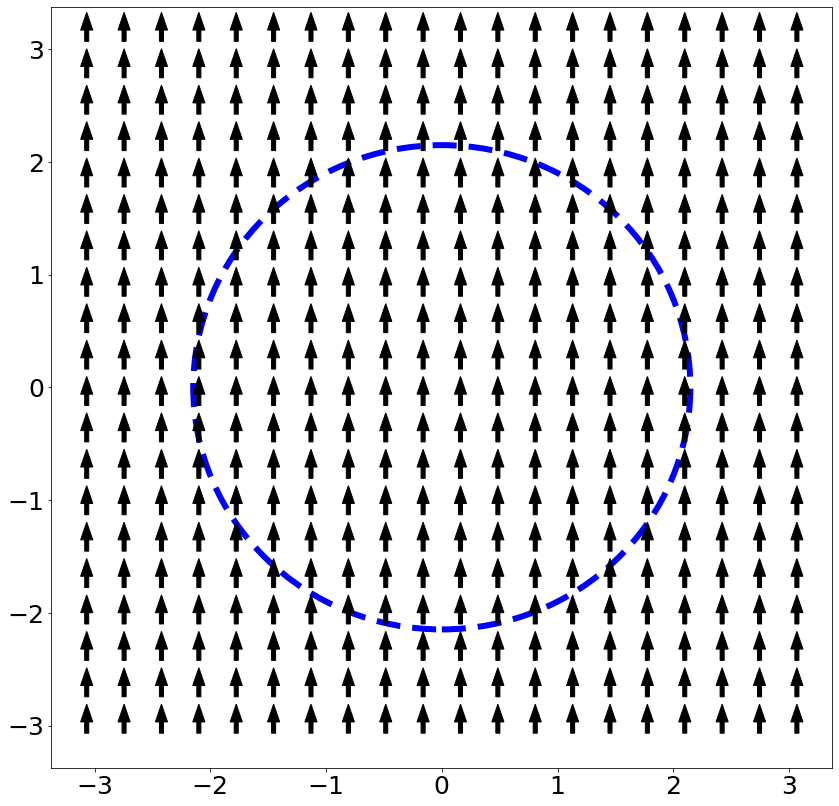

<Figure size 432x288 with 0 Axes>

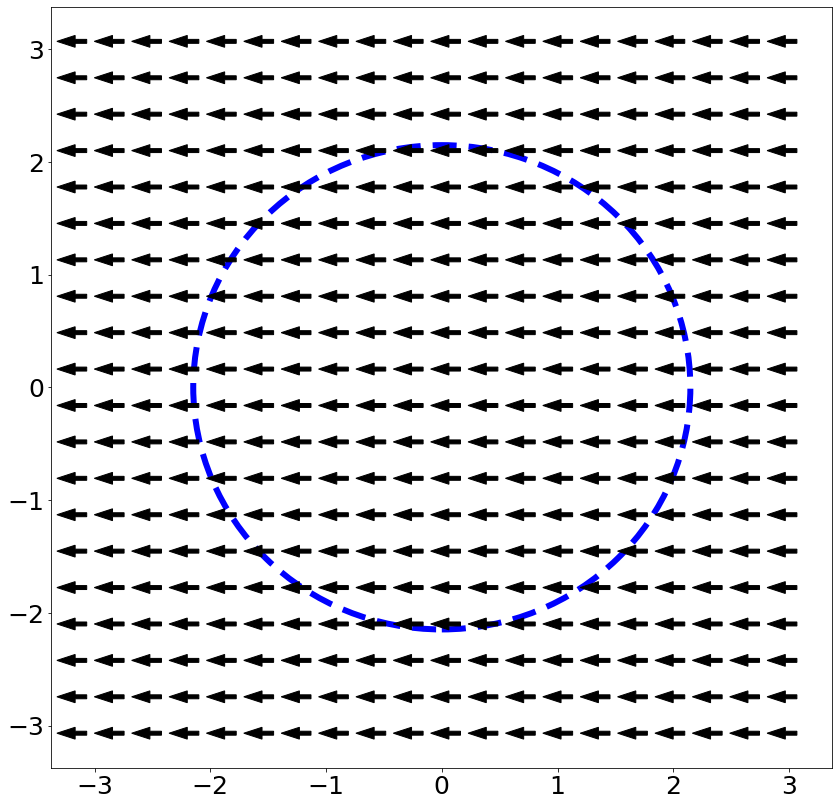

In [45]:
from jacobian import jacobian
from functools import partial

def forward_soro(soro,actuation):
    ps = soro(actuation)
    pos_EE = ps[:,-1,0:2,0]

    return pos_EE

# plot jacobian field
scale = 7
PI = np.pi
actuation_scale = 1/4096 * 2*PI 
r = 1400* actuation_scale

fig = plt.figure()
fig, ax = plt.subplots(figsize=(14,14))

# plot range of training data 
circle=plt.Circle((0,0),r, linewidth=6, edgecolor='b', facecolor='none', linestyle=(1,(4,2)), label="Training Data Range")
ax.add_patch(circle)
plt.arrow(x,y, 0,0, color='k', alpha=1, width=0, label='Gradient Field')

# Actuation 1
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    jac = torch.tensor([0,0.1])
    plt.arrow(x*actuation_scale,y*actuation_scale, jac[0], jac[1], color='k', alpha=1, width=0.035)
    
plt.xlim(-2200* actuation_scale, 2200* actuation_scale)
plt.ylim(-2200* actuation_scale, 2200* actuation_scale)
# ax.legend(fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()    

fig = plt.figure()
fig, ax = plt.subplots(figsize=(14,14))

# plot range of training data 
circle=plt.Circle((0,0),r, linewidth=6, edgecolor='b', facecolor='none', linestyle=(1,(4,2)), label="Training Data Range")
ax.add_patch(circle)
plt.arrow(x,y, 0,0, color='k', alpha=1, width=0, label='Gradient Field')

# Actuation 2
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    jac = torch.tensor([-0.1, 0])
    plt.arrow(x*actuation_scale,y*actuation_scale, jac[0], jac[1], color='k', alpha=1, width=0.035)

    
plt.xlim(-2200* actuation_scale, 2200* actuation_scale)
plt.ylim(-2200* actuation_scale, 2200* actuation_scale)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# ax.legend(fontsize=20)
plt.show()


# Measure Cosine Distance

In [46]:
from jacobian import jacobian
from functools import partial

# plot jacobian field
scale = 7
PI = np.pi
actuation_scale = 1/4096 * 2*PI 
r = 1400* actuation_scale

x = torch.linspace(-2000, 2000, 50)
y = torch.linspace(-2000, 2000, 50)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

fig = plt.figure()
fig, ax = plt.subplots(figsize=(14,14))

# plot range of training data 
circle=plt.Circle((0,0),r, linewidth=6, edgecolor='b', facecolor='none', linestyle=(1,(10,5)), label="Training Data Range")
ax.add_patch(circle)
plt.arrow(x,y, 0,0, color='k', alpha=1, width=0, label='Gradient Field')

# Actuation 1
jacobian_pred_a1_list = []
for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    
    jacobian_pred_a1_list.append(dict(pos = actuation, jac = jac[0,:,0,1].detach()))
    jac_act1 = jac[0,:,0,0] * scale / actuation_scale
    
    # plot field
    ax.arrow(x* actuation_scale, y* actuation_scale, jac_act1[0], jac_act1[1], color='k', alpha=1, width=0.035)
    
plt.xlim(-2200* actuation_scale, 2200* actuation_scale)
plt.ylim(-2200* actuation_scale, 2200* actuation_scale)
# ax.legend(fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()    

fig = plt.figure()
fig, ax = plt.subplots(figsize=(14,14))

# plot range of training data 
circle=plt.Circle((0,0),r, linewidth=6, edgecolor='b', facecolor='none', linestyle=(1,(10,5)), label="Training Data Range")
ax.add_patch(circle)
plt.arrow(x,y, 0,0, color='k', alpha=1, width=0, label='Gradient Field')

# get jacobian
jacobian_pred_a2_list = []

for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    
    jacobian_pred_a2_list.append(dict(pos = actuation, jac = jac[0,:,0,1].detach()))
    jac_act2 = jac[0,:,0,1] * scale / actuation_scale

    # plot field
    plt.arrow(x* actuation_scale, y* actuation_scale, jac_act2[0], jac_act2[1], color='k', alpha=1, width=0.035)
    
    
plt.xlim(-2200* actuation_scale, 2200* actuation_scale)
plt.ylim(-2200* actuation_scale, 2200* actuation_scale)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# ax.legend(fontsize=20)
plt.show()


In [ ]:
interpolation_error_list = []
extrapolation_error_list = []

assert len(jacobian_pred_a1_list) == len(jacobian_pred_a2_list)
length = len(jacobian_pred_a1_list)

jacobian_true_a1 = torch.tensor([0,0.1])
jacobian_true_a2 = torch.tensor([-0.1,0])

for i in range(len(jacobian_pred_a1_list)):
    
    pos1 = jacobian_pred_a1_list[i]['pos']
    jac1 = jacobian_pred_a1_list[i]['jac']
    error = 1 - (torch.nn.CosineSimilarity(dim=0)(jac1, jacobian_true_a1))
    if torch.norm(pos1) > 1400:
        extrapolation_error_list.append(error)
    else:
        interpolation_error_list.append(error)


    pos2 = jacobian_pred_a2_list[i]['pos']
    jac2 = jacobian_pred_a2_list[i]['jac']
    error = 1 - (torch.nn.CosineSimilarity(dim=0)(jac2, jacobian_true_a2))
    if torch.norm(pos2) > 1400:
        extrapolation_error_list.append(error)
    else:
        interpolation_error_list.append(error)
        
interpolation_error_array = np.array(interpolation_error_list)
extrapolation_error_array = np.array(extrapolation_error_list)

interpolation_error_array.mean(), extrapolation_error_array.mean()

(0.52585536, 0.9520776)